In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
import torch
import numpy as np

In [3]:
import abbyy_course_cvdl_t2

In [4]:
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [5]:
import abbyy_course_cvdl_t2
TINY_COCO_BASE = Path(abbyy_course_cvdl_t2.__file__).parent.parent / 'data'
TINY_COCO_BASE.exists()

True

In [6]:
from torchvision.datasets import CocoDetection

Если CocoDetection падает, вероятно, вам нужно установить pycocotools: `pip install pycocotools`

Раньше pycocotools требовал предварительную установки cython:
`pip install cython`
Раньше установка на windows работала криво: https://stackoverflow.com/questions/52920222/could-not-install-pycocotools-in-windows-fatal-error-c1083-cannot-open-include

На новых версиях python на windows теперь работает ок.

In [7]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [8]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection

In [9]:
ds_text = CocoTextDetection(
    Path("/home/alexander/Downloads/coco2014/images/train2014"),
    Path("/home/alexander/Downloads/coco2014/cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(256,256), ids_map = {1: 0, 0:0}
),
    area_fraction_threshold=1/32/32
)

In [10]:
x, y = ds_text[6]

In [11]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

/tmp/ipykernel_68999/4024544524.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  yc - hy//2 - thick : yc - hy//2 + thick,
/tmp/ipykernel_68999/4024544524.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  xc - wx//2 : xc + wx//2,
/tmp/ipykernel_68999/4024544524.py:15: UserWarning: __floordiv__ is deprecated, and its behavior wil

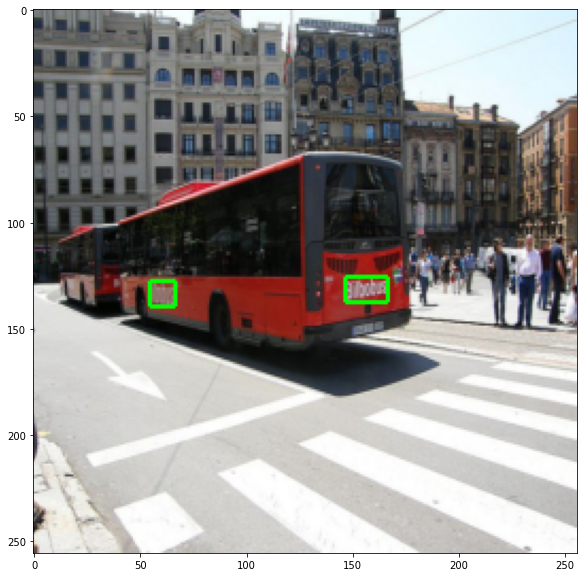

In [12]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [13]:
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [14]:
net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=1))
print(net)

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet18Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [15]:
net = train(ds_text, net=net, criterion=crit, batch_size=64, epochs=30, device=torch.device('cuda:0'), lr=1e-3)

epoch 0|0; total loss:485.3930969238281
last losses: [14434.48046875, 38.260009765625, 89.05189514160156]
epoch 0|30; total loss:573.1078491210938
last losses: [200.60845947265625, 45.06733322143555, 40.81378173828125]
epoch 0|60; total loss:302.003173828125
last losses: [200.2215576171875, 37.44244384765625, 34.550148010253906]
epoch 0|90; total loss:263.60577392578125
last losses: [166.63194274902344, 39.090057373046875, 33.299354553222656]
epoch 0|120; total loss:266.65362548828125
last losses: [184.5361328125, 45.00994110107422, 46.5863151550293]
epoch 0|150; total loss:263.2697448730469
last losses: [226.218505859375, 55.67460632324219, 62.32453536987305]
epoch 0|180; total loss:247.2783660888672
last losses: [182.002685546875, 44.16399383544922, 39.0754508972168]
epoch 0|210; total loss:248.02828979492188
last losses: [163.81427001953125, 46.061458587646484, 38.83695602416992]
epoch 0|240; total loss:245.1102294921875
last losses: [142.6436767578125, 40.57771301269531, 31.1986198

In [22]:
torch.save(net, 'centernet.pth')

In [17]:
with torch.no_grad():
    yp_heat = net(x[None].to('cuda:0')).cpu()    
    yp = net(x[None].to('cuda:0'), return_objects=True).cpu()

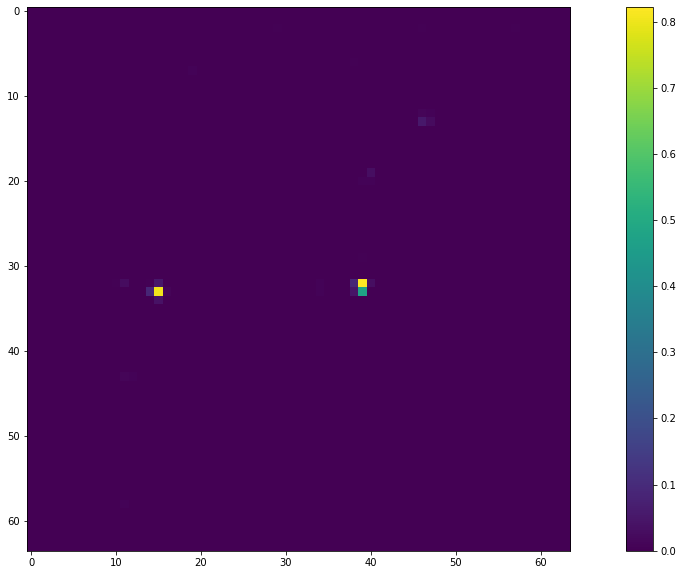

In [18]:
plt.imshow(yp_heat[0, 0])
plt.colorbar()

In [19]:
yp[0][:20]

tensor([[131.5201, 156.0000,   0.0000,   0.0000,   0.0000,   0.8217],
        [132.0000,  60.0000,   0.0000,   0.0000,   0.0000,   0.8028],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,  

In [20]:
y[:6]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

/tmp/ipykernel_68999/4024544524.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  yc - hy//2 - thick : yc - hy//2 + thick,
/tmp/ipykernel_68999/4024544524.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  xc - wx//2 : xc + wx//2,
/tmp/ipykernel_68999/4024544524.py:15: UserWarning: __floordiv__ is deprecated, and its behavior wil

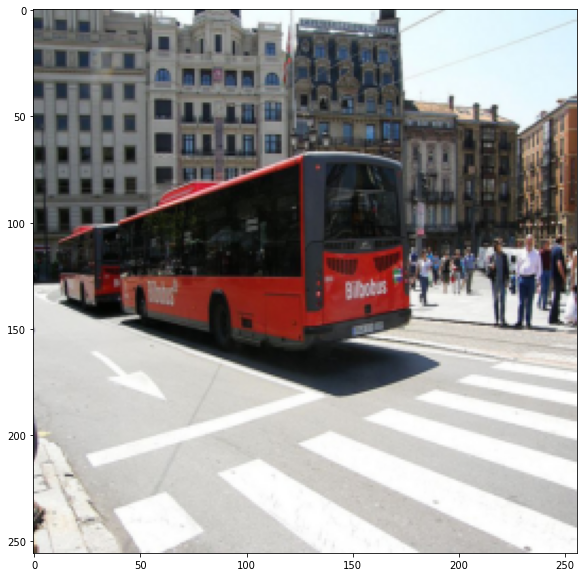

In [21]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
));